# Gradient Descent, the Normal Equation, Learning Rates, and why all of this matters for Linear Regression

Linear regression is typically used as the hello world for data science. It's one of the oldest machine learning models (designed far before machines could learn) but, despite being so old, it's far from being the simplest model. Understanding linear regression is also the first step toward understanding more sophisticated models like logistic regression, support vector machines, and even deep learning models.

Below I'll get into some of the nitty-gritty of linear regression so that those reading can have a deeper understanding of how the model works and, if you choose, create your own implementation of it.

I don't see any point in waiting, so, let's dive into the code and do some necessary imports.

We'll use `numpy` for speed, and `minmax_scale`, `train_test_split`, and `r2_score` from `sklearn` for convenience and `LinearRegression` from `sklearn` to test some of our implementations. We've also imported `time` and `altair` to compare the time complexity of one of our implementations against `sklearn`'s and `pandas` to store our data when plotting in `altair`.

In [1]:
import numpy as np

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import minmax_scale
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

import pandas as pd
# import altair as alt

from time import time
import pickle

Rather than direct everyone to a potentially broken link, feel free to test any implementations using the code below to generate data.

In [2]:
def create_data(n_feats=8, n_obs=1000):
    features = ('f' + str(x) for x in range(n_feats))
    target = abs(np.random.normal(1000, 250, n_obs))
    feat_vals = []
    for feature in features:
        feat_vals.append(np.fromiter((np.random.normal(
                            abs(np.random.normal(target[i],
                            abs(np.random.normal(100, 30)))))
                            for i in range(n_obs)), dtype='float'))
    X = np.array(feat_vals).T
    return X, target

In [4]:
X, target = create_data(n_feats=8, n_obs=1000)
X_scaled = minmax_scale(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, target,
                                                    test_size=0.33,
                                                    random_state=42)

## The Line of Best Fit

We can't talk about machine learning models like Linear Regression without first quickly reviewing where these models come from.  

The great grandfather of linear regression is the line of best fit. You use it when you have a single input variable and a single output variable. That's when it works.

Given $n \times 1$ explanatory and response variables, we can calculate the slope and intercept of the line of best fit.

In [5]:
x_train = X_train[:, 0]
x_test = X_test[:, 0]

x_mean = x_train.mean()
y_mean = y_train.mean()
m = ((x_train - x_mean) * (y_train - y_mean)).sum() / ((x_train - x_mean)**2).sum()
b = y_mean - m * x_mean
preds = m * x_test + b
1 - ((y_test - preds)**2).sum() / ((y_test - y_mean)**2).sum()        

0.858485601107073

This can be done without iteration. We simply find the slope of the line (`m`) and then use that while calculating our intercept (`b`).  

We can see that the prediction is (almost) the same as when we use sklearn's LinearRegression

In [6]:
LinearRegression().fit(x_train.reshape(-1, 1), y_train).score(x_test.reshape(-1, 1), y_test)

0.8584853089226635

## Normal Equation Method
The line of best fit works when we have a single explanatory variable. What do we do when we have multiple explanatory variables? For that we take a huge leap forward in complexity and use the normal equation; the equation that we get from differentiating the residual sum of squares equation.

The derivative of RSS deserves it's entire own blog/video, fortunately it's already been done a million times over. Search for your own explanation or just look at this [video](https://www.youtube.com/watch?v=K_EH2abOp00) or at [wiki](https://en.wikipedia.org/wiki/Proofs_involving_ordinary_least_squares) for both the matrix and summation notation.

Ultimately, when we differentiate the residual sum of squares equation:  
$RSS={\bigl \|}\mathbf {y} -\mathbf {X}{\beta }{\bigl \|}^2$  
we get:  
$(\mathbf {X} ^{\rm {T}}\mathbf {X} )^{-1}\mathbf {X} ^{\rm {T}}\mathbf {y} =0$  

This is the equation that we'll use in our next example.

In [3]:
class NormalEquation:
    
    def __init__(self):
        pass
    
    def __repr__(self):
        return "OLS()"
    
    def fit(self, X_train, y_train):
        # Our new column that we'll call intercept
        # We make it based on the shape of the first column in our training data
        intercept = np.ones_like(X_train[:, 0])
        
        # We add our new column to our training data and create a new variable
        X_train_int = np.insert(X_train, 0, intercept, axis=1)
        
        # Use the normal equation
        # (X_train_int.T @ X_train_int)^-1 = ((k x n) @ (n x k))^-1 -> k x k
        # X_train_int.T = (k x n)
        # y_train = (n x 1)
        # coefs = (k x k) @ (k x n) @ (n x 1) -> k x 1
        coefs = np.linalg.inv(X_train_int.T @ X_train_int) @ X_train_int.T @ y_train
        
        # Save our coefficients for later use
        self.coefs_ = coefs
        return self
    
    def predict(self, X_test):
        # Again, we create a new column for the test data
        intercept = np.ones_like(X_test[:, 0])
        X_test_int = np.insert(X_test, 0, intercept, axis=1)
        
        # preds = (n x k) @ (k x 1) = n x 1
        preds = X_test_int @ self.coefs_
        return preds
    
    def score(self, X_test, y_test):
        # Again, we create a new column for the test data
        intercept = np.ones_like(X_test[:, 0])
        X_test_int = np.insert(X_test, 0, intercept, axis=1)

        # preds = (n x k) @ (k x 1) = n x 1
        preds = X_test_int @ self.coefs_
        
        # Here we're simply calculating r-squared
        score = 1 - ((y_test - preds)**2).sum() / ((y_test - y_test.mean())**2).sum()
        return score

In [18]:
NormalEquation().fit(X_train, y_train).score(X_test, y_test)

0.9729673284160013

For anyone who didn't dig into the above model, it's worth pointing out separately that the equation to determine the coefficients for our linear model is just this one liner. (_The `int` in the variable name `X_train_int` refers to the fact that we've added a column on `1`s to act as the **int**ercept_).
``` python
coefs = np.linalg.inv(X_train_int.T @ X_train_int) @ X_train_int.T @ y_train
```

If you didn't add the column of ones, the equation would calculate all coefficients given an intercept of `0`. 

A quick thought experiment for you:  

> Think about how one would account for an intercept using the normal equation without adding the column of ones.
>> Hint: what does the intercept do, and what might you do so that an intercept of `0` is the ideal intercept?

Side note:  
> _For anymore unfamiliar with the `__repr__` "dunder", try deleting it and finding out what changes. If you'd like to learn more, I strongly recommend reading [Fluent Python](http://index-of.es/Varios-2/Fluent%20Python%20Clear%20Concise%20and%20Effective%20Programming.pdf). In it, they go over `__repr__` and some of the other "magic methods" found in python and how they compare to those found in other programming languages (as well as pretty much anything else you would ever want to know about python)._

Below, I've timed and plotted the duration of `sklearn`'s gradient descent implementation against the normal equation _(the amount of code required was a bit excessive for this blog, if you would like to see how I tested this, please feel free to checkout my [github repository](https://github.com/keith12345/LinearRegression) for this post)_.

You can see that while the normal equation is initially faster, the duration eventually overtakes the gradient descent implementation due to its quadratic/cubic time complexity.

> Diving a bit deeper into the normal equation's time complexity, we can take note of the following given $n$ observations and $k$ features:
> * $X^TX$ -> O($k^2n$)
> * $X^Ty$ -> O($kn$)
> * $(X^TX)^{-1}(X^Ty)$ -> O($k^3$)
>
> O($k^2n$) grows asymptotically, far faster than O($kn$). As we're using the normal equation, $n$ will always need to be greater than or equal to $k+1$ (we add the $+1$ for our column of zeros) for the sake of matrix invertibility. That means that O($k^2n$) is either greater than or equal to O($k^3$).
>
> In my example, I'll be using a square matrix for the sake of worst-case-scenario time complexity.

Mini-batch gradient descent, on the other hand, has no objectively true time complexity as is explained eloquently by Kandasamy Illanko in a answer of his on [Quora](https://www.quora.com/Whats-the-time-complexity-and-convergence-rate-for-using-stochastic-gradient-descent-in-deep-learning).

It's worth noting that if you were performing a task that did not require huge amounts of data and did require extremely fast training without regularization, a simple custom implementation of the normal equation might be the ideal model choice. 

In [14]:
X, target = create_data(5_000, 5_000)

In [15]:
file = open("Data/"+str(X.shape[0])+"_X.pkl", "wb")
pickle.dump(X, file)
file.close()

file = open("Data/"+str(X.shape[0])+"_y.pkl", "wb")
pickle.dump(target, file)
file.close()

In [16]:
file = open("Data/10000_X.pkl", "rb")
X = pickle.load(file)
file.close()

file = open("Data/10000_y.pkl", "rb")
target = pickle.load(file)
file.close()

FileNotFoundError: [Errno 2] No such file or directory: 'Data/10000_X.pkl'

In [19]:
new_feats = ('f' + str(x) for x in range(X.shape[1]))
new_targs = abs(np.random.normal(1_000, 250, 5_000))
new_feat_vals = []
for feature in new_feats:
    new_feat_vals.append(np.fromiter((np.random.normal(
                        abs(np.random.normal(new_targs[i],
                        abs(np.random.normal(100, 30)))))
                        for i in range(5_000)), dtype='float'))
new_X = np.array(new_feat_vals).T
new_X = minmax_scale(new_X)

# Add features for new observations
X = np.append(X, new_X, axis=0)

# Add new target for new observations
target = np.append(target, new_targs, axis=0)

# Creates new features for new and existing observations
new_feats = ('f' + str(x) for x in range(5_000))
new_feat_vals = []
for feature in new_feats:
    new_feat_vals.append(np.fromiter((np.random.normal(
                        abs(np.random.normal(target[i],
                        abs(np.random.normal(100, 30)))))
                        for i in range(target.shape[0])), dtype='float'))
new_X = np.array(new_feat_vals).T
new_X = minmax_scale(new_X)

# Add new features to modifed matrix
X = np.append(X, new_X, axis=1)


feats_name = "Data/feats_%s_x_%s.pkl" % (str(X.shape[0]), str(X.shape[1]))
targs_name = "Data/targs_%s.pkl" % str(target.shape[0])


file = open("Data/"+str(X.shape[0])+"_X.pkl", "wb")
pickle.dump(X, file)
file.close()

file = open("Data/"+str(X.shape[0])+"_y", "wb")
pickle.dump(target, file)
file.close()

In [35]:
norml_equat_time = []
sklrn_model_time = []
sklrn_njms1_time = []

for _ in range(100):
        
    # Create pickle names
    feats_name = "Data/feats_%s_x_%s.pkl" % (str(X.shape[0]), str(X.shape[1]))
    targs_name = "Data/targs_%s.pkl" % str(target.shape[0])
    
    # Save pickled features
#     pickle.dump(X, open(feats_name, "wb"))
#     pickle.dump(target, open(targs_name, "wb"))
    
    # Sublists for taking average run-time
    norml_equat_time_sub = []
    sklrn_model_time_sub = []
    sklrn_njms1_time_sub = []

    for _ in range(3):

        start = time()
        NormalEquation().fit(X, target)
        end = time()
        norml_equat_time_sub.append(end - start)

        start = time()
        LinearRegression().fit(X, target)
        end = time()
        sklrn_model_time_sub.append(end - start)
        
        start = time()
        LinearRegression(n_jobs=-1).fit(X, target)
        end = time()
        sklrn_njms1_time_sub.append(end - start)

    # Add average time to list
    norml_equat_time.append(sum(norml_equat_time_sub)/3)
    sklrn_model_time.append(sum(sklrn_model_time_sub)/3)
    sklrn_njms1_time.append(sum(sklrn_njms1_time_sub)/3)
    
    # Save results for each iteration in the even the loop
    # terminates early
    results = [norml_equat_time, sklrn_model_time, sklrn_njms1_time]
    results_name = "Data/results_%s.pkl" % str(target.shape[0])
    
    file = open(results_name, "wb")
    pickle.dump(results, file)
    file.close()
    
    print(time())
    
    # Creates new observations with same number of features
    # as existing matrix
    new_feats = ['f' + str(x) for x in range(X.shape[1])]
    new_targs = abs(np.random.normal(1_000, 250, 10_000))
    new_feat_vals = []
    for feature in new_feats:
        new_feat_vals.append([np.random.normal(
                            abs(np.random.normal(new_targs[i],
                            abs(np.random.normal(100, 30)))))
                            for i in range(10_000)])
    new_X = np.array(new_feat_vals).T
    new_X = minmax_scale(new_X)

    # Add features for new observations
    X = np.append(X, new_X, axis=0)

    # Add new target for new observations
    target = np.append(target, new_targs, axis=0)

    # Creates new features for new and existing observations
    new_feats = ['f' + str(x) for x in range(1_000)]
    new_feat_vals = []
    for feature in new_feats:
        new_feat_vals.append([np.random.normal(
                            abs(np.random.normal(target[i],
                            abs(np.random.normal(100, 30)))))
                            for i in range(X.shape[0])])
    new_X = np.array(new_feat_vals).T
    new_X = minmax_scale(new_X)

    # Add new features to modifed matrix
    X = np.append(X, new_X, axis=1)

1570512401.640782
1570512594.8112147
1570512964.3425307
1570513500.7686107
1570514275.7106183
1570515348.3677688
1570516795.2820206
1570518511.6407208
1570521918.6292152
1570533612.2890399


MemoryError: 

In [7]:
results

[[1.1736381848653157, 3.9579219818115234, 8.806887944539389],
 [2.088935295740763, 6.322096506754558, 15.52100928624471],
 [1.8901692231496174, 6.400180339813232, 15.898442586263021]]

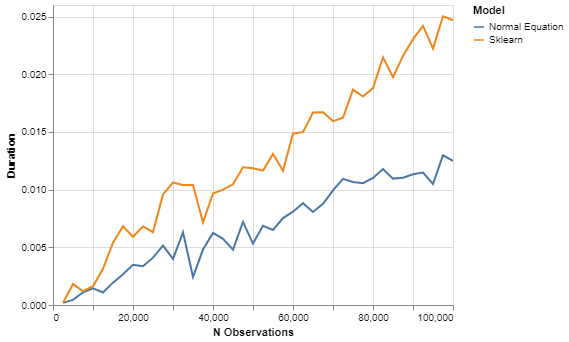

In [52]:

x = np.arange(100)
source = pd.DataFrame({
    'Duration': normal_equation + sklearn_LinRegr,
    'Model':['Normal Equation'] * 40 + ['Sklearn'] * 40,
    'N Observations': list(n_observations) * 2
})

alt.Chart(source).mark_line().encode(
    x='N Observations',
    y='Duration',
    color='Model'
)


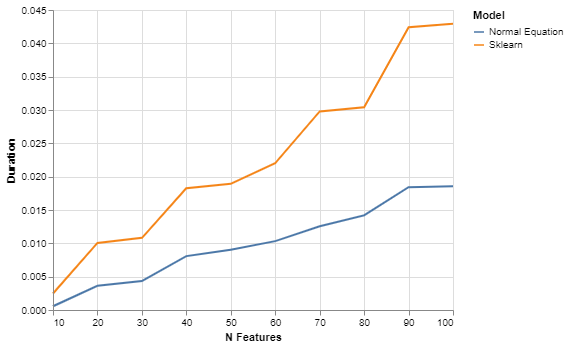

In [67]:
import pandas as pd

x = np.arange(100)
source = pd.DataFrame({
    'Duration': normal_equation + sklearn_LinRegr,
    'Model':['Normal Equation'] * 10 + ['Sklearn'] * 10,
    'N Features': list(n_feats) * 2
})

alt.Chart(source).mark_line().encode(
    x='N Features',
    y='Duration',
    color='Model'
)


## Stochastic Gradient Descent

While the normal equation above is incredibly fast given the size of our data (for those who didn't try it on their own, it's actually significantly faster than sklearn for a dataset of this size), it does not scale particularly well; that's why we typically use gradient descent in practice.

Below I'll walk through taking the derivative of the cost function for gradient descent as well as provide some sudo code to warm us up before we dive into any more full fledged models.

I'll walk through this derivative both becuase it is simpler than the derivative of RSS and it's what you'd likely be expected to code if you were asked to create a linear regression model in an interview. Knowing how to derive it on your own should help you remember how to build it when necessary.

### Differentiating Gradient Descent

We start with a single squared error, or the _definition of the cost function_ which you can see below using two types of notation:  

$ ((mx + b) - y)^2 $

and  

$\left(h_{\theta}(x^{(i)})-y^{(i)}\right)^2$

We'll use the first notation going forward.

As mentioned, we need to take the derivative of the cost function. We will take it with respect to both $m$ (our coefficient) and $b$ (our intercept).

#### Derivative with respect to $m$:  

$\frac{d}{dm}\left[((mx + b) - y)^2\right]$ ->  

$2 \times ((mx + b) - y) \frac{d}{dm}\left[((mx + b) - y)\right]$ ->  

$\frac{d}{dm} 2 \times ((mx + b) - y) \times x$  

We don't actually need the $2$ (we're minimizing this... it doesn't matter if we minimize $x$ or $2x$) so we just end up with:  

$\frac{d}{dm} ((mx + b) - y) \times x$  

#### Taking steps with $m$:  

We multiply the derivative by the learning rate to get our step.  
The code looks something like this:
``` python
pred = mx + b
error = pred - y
derivative = error * x
step = derivative * learning_rate
```
After taking the derivative with respect to $m$, the derivative with respect to $b$ should be slightly easier:

#### Derivative with respect to $b$:  

$\frac{d}{dm}\left[((mx + b) - y)^2\right]$ ->  

$2 \times ((mx + b) - y) \frac{d}{dm}\left[((mx + b) - y)\right]$ ->  

$\frac{d}{dm} 2 \times ((mx + b) - y) \times 1$ ->

$\frac{d}{dm} (mx + b) - y$

The only difference is that we're not multiplying $b$ by anything so it essentially dissappears after taking its derivative in the second stage of the chain.  

#### Taking steps with $b$:  
Now we take a look at the code (note how similar it is to the step for the coefficient, $m$):
``` python
pred = mx + b
error = pred - y
derivative = error
step = derivative * learning_rate
```

The step for the intercept ($b$) is just the error multiplied by the learning rate!  
The last two lines of code can obviously be simplified to `step = error * learning_rate`.  

### Combining what we've learned

This can be abstracted to matrix multiplication quite simply.  
Using `numpy`, the `@` operator will act as a matrix multiplier (`numpy` also has `arr.dot(arr2)` but I haven't noticed any performance improvments and I find `@` more readable). We simply swap out the `*` with `@` wherever we're multiplying matrices (but don't forget that order matters during matrix multiplication!).  
(_Note that due to matrix multiplication magic, this can work with a single observation, a batch of observations, or even an entire dataset._ You simply need to divide by the number of observations used in the calculation and multiply by the learning rate).
``` python
n = len(X[0])
pred = (X @ m) + b
error = (pred - y) * (1/n)
coefs -= error @ x * learning_rate
intercept -= error.sum() * learning_rate
```

### But why do we actually need a learning rate?

#### An analogy to get you thinking
Imagine you and 3 friends are trying to lift a table. The table weighs 100 pounds, but at the start each person is lifting only 10 pounds of the table's weight.

That's 40 pounds in total, so everyone combined is 60 pounds short of holding the entire weight of the table; they haven't managed to move/lift it yet.

If one person were to lift the remaining 60 pounds, they might manage to lift the table, but it would be lopsided (or maybe even flip!). We can compare this to modifying a single coefficient without using a learning rate. In this example, that one coefficient (person) would take the entire remaining weight of the table. 

If each one were to independently decide to lift the remaining 60 pounds, and they did so simultaneously, they would likely end up throwing the table into the air! We can compare this to over-fitting like _crazy_. Each coefficient is trying to do all of the work (lift the entire remaining weight of the table) on its own.

The solution is for everyone to constantly make small adjustments until they smoothly/evenly lift the table off of the floor with each person ultimately taking about 25 pounds of the table's weight. 

Furthering the comparison, if one side/corner of the table weighed more, then the person holding that side/corner would need to lift more. Lifting more weight would be like increasing the coefficient for that feature. Going on step further, when all people are lifting the same amount, it's like having 4 features with perfect multicolinearity. But, unlike a single perfectly weighted coefficient, we can't all lift a 100 pound table on our own.

#### Showing it with data:
Below I train a simple model without using a learning rate, i.e. no small adustments.  
This will result in **_extreme_** over-fitting as each coefficient will try to "explain" all of the change on its own.  
I'll demonstrate this by showing two examples. 

Below, we train our very simple model:

In [44]:
# Array of ones for our coefficients
m = np.zeros_like(X_train[0])
# The intercept
b = 0
# The number of oberservations
n = X_train.shape[0]

pred = X_train @ m + b
error = (2/n) * (y_train - pred)

d_m = error.T @ X_train
d_b = error.sum()

m += d_m
b += d_b

##### First example - Using the Intercept as a predictor:
The predicted `b` is equal to the mean of our target. The best (and only) prediction that can be made when there are no features (e.g. only an intercept and a target).  
Pop-quiz: What will the r-squared be if we make predictions using only the intercept, `b`?

In [45]:
print(b/2, "- The intercept that we've created")
print(y_train.mean(), "- The mean of the target")

984.8134405883508 - The intercept that we've created
984.8134405883509 - The mean of the target


##### Second example - Using only one of our coefficients:
The 8 coefficients without the intercept actually provide a reasonably accurate prediction for our target varianle. It makes sense that this works without the target variable because the adjustments that resulted in these coefficients were made without any knowledge that a y intercept might ever exist. They are the best fit given the available information. 

In [46]:
results = X_test @ m
r2_score(y_test, results/4)

0.9303584913819554

So, that's what happens you don't take steps!

One curiosity that you may have noticed is that I divided the results by 4. The number was not chosen at random. When one giant step is taken instead of performing gradient descent, it seems the features are typically k/2 times too large. 

I've been unable to determine the cause of the somewhat tenuous relationship but would love to hear from anyone who knows from where it originates!

Below I've plotted for numbers of k from 1 - 20 where you can see this relationship in action.

_Note that a decent r-squared is not always produced. I've used a random seed for the sake of reproducability of results_.

In [ ]:
for k in range(1, 21):
    
    np.random.seed(42)

    X, y = create_data(n_feats=8, n_obs=1_000)
    X = minmax_scale(X)

    m = np.zeros_like(X_train[0])
    b = 0
    n = X.shape[0]

    pred = X @ m + b
    error = (2/n) * (y - pred)

    d = error.T @ X
    d = error.sum()
    
    results = X @ m
    score = r2_score(y, results/(k/2))
    
    info = (k, b/2, y.mean(), score)
    
    print("%02d Features: %4.0f - Intercept, %4.0f - Mean, %.3f - r2_score" %  info)

Now let's go build a model that takes steps.

### Implementing a Stochastic Gradient Descent Model
Now we can finally start creating our gradient descent model!

I'm sure you can figure out most of what's going here but I'll point out a few things. We now have `learning_rate` and `max_iter` parameters. These weren't necessary for the normal equation because it's not iterative. Here we're taking steps; we need to know how big they are, and in case we're never going to converge, maybe it's just better to quit early and change your step size (and hopefully that allows you to converge... or just increase the number of iterations).

There are many more parameters that I could add to this model for any number of reasons, but these will do for our purposes.

In [26]:
class StochasticGradientDescent:
    
    def __init__(self, learning_rate=0.05, max_iter=1_000):
        self.l = learning_rate
        self.max_iter = max_iter
        
    def __repr__(self):
        parameters = (self.max_iter, self.l)
        return "LinearRegression(max_iter=%s, learning_rate=%s)" % parameters
    
    def _gradient_descent(self, x, y):
        # Remember that order matters for matrix multiplication but numpy
        # allows some flexibility when multiplying (k, ) matrices which
        # allows us to use 'mx + b' style notation
        pred = self.coefs_ @ x + self.intercept
        error = pred - y
        self.coefs_ -= error * x * self.l
        self.intercept -= error * self.l
    
    def fit(self, X_train, y_train):
        self.intercept = 0
        
        # Create a numpy array of arbitrarily valued coefficients
        # that will be updated as we iterate
        self.coefs_ = np.ones_like(X_train[0])
        
        i = 0
        
        # We keep track of our r-squared 
        # When the r-squared in no longer decreasing above a certain
        # rate. We've assume we've converged.
        old_rss = 0
        
        converged = False
        
        while not converged:
            for row in zip(X_train, y_train):
                
                # Array of feature values for a single observation
                x = row[0]
                
                # Target value for a single observation
                y_obs = row[1]
            
                # Perform gradient descent and update 
                # our coefficients and intercept
                self._gradient_descent(x, y_obs)
            
            # Create predictions
            pred = (X_train @ self.coefs_) + self.intercept
            
            # Calculate the rss for those predictions
            new_rss = np.square(pred - y_train).sum() / pred.shape[0]
            
            i += 1
            
            # Check the change in rss
            if abs((old_rss) - (new_rss)) < 1e-3:
                converged = True
            if i >= self.max_iter:
                print("Failed to converged after %s iterations." % i)
                return self
                
            # Update the old r-squared
            old_rss = new_rss
        
        return self
        
    def predict(self, X_test):
        preds = (X_test @ self.coefs_) + self.intercept
        return preds
    
    def score(self, X_test, y_test):
        preds = (X_test @ self.coefs_) + self.intercept
        return r2_score(y_test, preds)

In [27]:
StochasticGradientDescent(max_iter=100).fit(X_train, y_train).score(X_test, y_test)

0.9635397126696881

## Batch Gradient Descent

While stochastic gradient descent gets the job done, it's not the ideal model. Such frequent steps result in noisy updates for the coefficients on their way to the minima and convergence typically takes significantly longer. One way to counteract this is via batch gradient descent. 

In essence, batch gradient descent looks over the entire set of training data and takes the average of the steps indicated. This provides a significantly more robust solution for calculating the step size.

However, batch gradient descent is not without it's shortcominings. It uses the entire set of training data for each step. This can potentially be millions of observations multiplied by thousands of features. This becomes quite expensive as the number of iterations increases. 

This problem is solved via mini-bath gradient descent in which a random subset of observations are used for each iteration. Here, I've decided to take the square root of the number of observations. 

### Mini-Batch Gradient Descent

In [28]:
class MiniBatchGradientDescent:
    
    def __init__(self, max_iter=1_000, learning_rate=.05):
        self.max_iter = max_iter
        self.learning_rate = learning_rate
    
    def __repr__(self):
        parameters = (self.max_iter, self.learning_rate)
        return "LinearRegression(max_iter=%s, learning_rate=%s)" % parameters
    
    def _gradient_descent(self, X, y):
        pred = X @ self.coefs_ + self.intercept
        error = (1/self.batch_size) * (pred - y)

        # error.T = (1 x n) 
        # X = (n x k) 
        # error @ k -> (k x 1)
        # These will become our updated coefficients
        d_coefs = error.T @ X
        d_intercept = error.sum()

        self.coefs_ -= self.learning_rate * d_coefs
        self.intercept -= self.learning_rate * d_intercept
    
    def fit(self, X_train, y_train):
        self.coefs_ = np.zeros_like(X_train[0])
        self.intercept = 0
        
        # Our number of observations
        n = X_train.shape[0]
        
        # Calculating batch size from number of observations
        self.batch_size = int(np.sqrt(n))
        
        # Keeping track of number of iterations
        i = 0
        
        old_rss = 0
        converged = False

        while not converged:
            batch_indices = np.random.choice(n, self.batch_size)
            X_batch = X_train[batch_indices, :]
            y_batch = y_train[batch_indices]
            
            # Perform gradient descent and update 
            # our coefficients and intercept
            self._gradient_descent(X_batch, y_batch)

            pred = (X_train @ self.coefs_) + self.intercept
            new_rss = np.square(pred - y_train).sum() / pred.shape[0]
            
            i += 1
            if abs((old_rss) - (new_rss)) < 1e-3:
                converged = True
            if i >= self.max_iter:
                return self, print("Failed to converged after %s iterations." % i)
            old_rss = new_rss
            
        return self
        
    def predict(self, X_test):
        preds = (X_test @ self.coefs_) + self.intercept
        return preds
    
    def score(self, X_test, y_test):
        preds = (X_test @ self.coefs_) + self.intercept
        return r2_score(y_test, preds)

In [29]:
MiniBatchGradientDescent(max_iter=10_000).fit(X_train, y_train).score(X_test, y_test)

0.972384194585432

There you have it; there's mini-batch gradient descent.

Not as fast or as reliable as sklearn's model, but an understanding of what is happening in the above will be a great asset if you ever need to understand how linear regression works under the hood.

I hope you've enjoyed reading this as much as I went crazy writing it!